In [30]:
!pip install svgwrite cairosvg

In [33]:
import matplotlib
matplotlib.use('Agg')  # or try 'Qt5Agg' if TkAgg doesn't work

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, spatial
from sklearn.cluster import DBSCAN
import svgwrite
import cairosvg
import scipy.interpolate as interpolate

# Utility Functions

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(path_XYs):
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        if isinstance(XYs, np.ndarray):
            if XYs.ndim == 2:
                ax.plot(XYs[:, 0], XYs[:, 1], c=c, linewidth=2)
            elif XYs.ndim == 1:
                XYs_reshaped = XYs.reshape(-1, 2)
                ax.plot(XYs_reshaped[:, 0], XYs_reshaped[:, 1], c=c, linewidth=2)
        elif isinstance(XYs, list):
            for XY in XYs:
                if isinstance(XY, np.ndarray):
                    if XY.ndim == 2:
                        ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
                    elif XY.ndim == 1:
                        XY_reshaped = XY.reshape(-1, 2)
                        ax.plot(XY_reshaped[:, 0], XY_reshaped[:, 1], c=c, linewidth=2)
                elif isinstance(XY, list):
                    XY_array = np.array(XY)
                    if XY_array.ndim == 2:
                        ax.plot(XY_array[:, 0], XY_array[:, 1], c=c, linewidth=2)
                    elif XY_array.ndim == 1:
                        XY_reshaped = XY_array.reshape(-1, 2)
                        ax.plot(XY_reshaped[:, 0], XY_reshaped[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def convert_to_polyline(points):
    return np.array(points)

# Regularize Curves

def identify_straight_line(points, threshold=0.05):
    A = np.c_[points[:, 0], np.ones(len(points))]
    b = points[:, 1]
    solution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    vx, vy = solution
    residuals = np.abs(vy * points[:, 0] - points[:, 1] + vx) / np.sqrt(vy**2 + 1)
    return np.mean(residuals) < threshold

def identify_circle(points, threshold=0.1):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0]-xc)**2 + (points[:, 1]-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(points, axis=0)
    center, _ = optimize.leastsq(f_2, center_estimate)

    radius = np.mean(calc_R(*center))
    residuals = np.abs(calc_R(*center) - radius)
    return np.mean(residuals) < threshold * radius

def identify_ellipse(points, threshold=0.1):
    def fit_ellipse(x, y):
        D = np.column_stack((x**2, x*y, y**2, x, y, np.ones_like(x)))
        S = np.dot(D.T, D)
        C = np.zeros((6, 6))
        C[0, 2] = C[2, 0] = 2; C[1, 1] = -1
        E, V = np.linalg.eig(np.dot(np.linalg.inv(S), C))
        n = np.argmax(np.abs(E))
        a = V[:, n]
        return a

    x, y = points[:, 0], points[:, 1]
    a = fit_ellipse(x, y)
    center = np.array([(a[4]*a[2]-a[1]*a[3]), (a[0]*a[3]-a[4]*a[1])]) / (a[1]**2-a[0]*a[2])

    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    return np.std(distances) / np.mean(distances) < threshold

def identify_rectangle(points, angle_threshold=5, side_ratio_threshold=0.2):
    hull = spatial.ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) != 4:
        return False

    edges = np.roll(hull_points, -1, axis=0) - hull_points
    angles = np.abs(np.arctan2(edges[:, 1], edges[:, 0]) * 180 / np.pi)
    angle_diffs = np.abs(angles - np.roll(angles, 2))

    if not np.all(angle_diffs < angle_threshold):
        return False

    lengths = np.linalg.norm(edges, axis=1)
    length_ratios = lengths / np.roll(lengths, 2)

    return np.all(np.abs(length_ratios - 1) < side_ratio_threshold)

def identify_regular_polygon(points, num_sides, threshold=0.1):
    hull = spatial.ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) != num_sides:
        return False

    edges = np.roll(hull_points, -1, axis=0) - hull_points
    lengths = np.linalg.norm(edges, axis=1)
    angles = np.abs(np.arctan2(edges[:, 1], edges[:, 0]))

    length_variation = np.std(lengths) / np.mean(lengths)
    angle_variation = np.std(np.diff(angles)) / np.mean(np.diff(angles))

    return length_variation < threshold and angle_variation < threshold

def identify_rounded_rectangle(points, angle_threshold=5, side_ratio_threshold=0.2, corner_threshold=0.1):
    hull = spatial.ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) < 4:
        return False

    edges = np.roll(hull_points, -1, axis=0) - hull_points
    angles = np.abs(np.arctan2(edges[:, 1], edges[:, 0]) * 180 / np.pi)
    angle_diffs = np.abs(angles - np.roll(angles, 2))

    if not np.all(angle_diffs < angle_threshold):
        return False

    lengths = np.linalg.norm(edges, axis=1)
    length_ratios = lengths / np.roll(lengths, 2)

    if not np.all(np.abs(length_ratios - 1) < side_ratio_threshold):
        return False

    # Check for rounded corners
    corner_points = hull_points
    for i in range(len(corner_points)):
        prev = corner_points[i-1]
        curr = corner_points[i]
        next = corner_points[(i+1) % len(corner_points)]

        vec1 = prev - curr
        vec2 = next - curr
        angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

        if abs(angle - np.pi/2) > corner_threshold:
            return False

    return True

def identify_star_shape(points, threshold=0.2):
    hull = spatial.ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) < 10:  # Assuming at least a 5-pointed star
        return False

    edges = np.roll(hull_points, -1, axis=0) - hull_points
    lengths = np.linalg.norm(edges, axis=1)

    # Check for alternating long and short edges
    even_lengths = lengths[::2]
    odd_lengths = lengths[1::2]

    # Ensure even and odd lengths have the same size
    min_length = min(len(even_lengths), len(odd_lengths))
    long_short_ratio = even_lengths[:min_length] / odd_lengths[:min_length]

    return np.std(long_short_ratio) / np.mean(long_short_ratio) < threshold

# Bezier Utility Functions

def fit_cubic_bezier(p0, p1, p2, p3):
    # Returns a cubic Bézier curve from four control points.
    return lambda t: (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def polyline_to_bezier(points):
    # Fit cubic Bézier curves to the polyline points
    if len(points) < 4:
        return points

    bezier_curves = []
    for i in range(0, len(points) - 3, 3):
        p0, p1, p2, p3 = points[i:i+4]
        bezier_curves.append(fit_cubic_bezier(p0, p1, p2, p3))

    return bezier_curves

def fit_circle_bezier(points):
    # Fit a circle to the points
    x, y = points[:, 0], points[:, 1]
    x_m = np.mean(x)
    y_m = np.mean(y)
    u = x - x_m
    v = y - y_m
    S_uv = np.sum(u*v)
    S_uu = np.sum(u**2)
    S_vv = np.sum(v**2)
    S_uuv = np.sum(u**2 * v)
    S_uvv = np.sum(u * v**2)
    S_uuu = np.sum(u**3)
    S_vvv = np.sum(v**3)

    A = np.array([[S_uu, S_uv], [S_uv, S_vv]])
    B = np.array([S_uuu + S_uvv, S_vvv + S_uuv]) / 2.0
    uc, vc = np.linalg.solve(A, B)
    xc, yc = uc + x_m, vc + y_m
    R = np.sqrt(uc**2 + vc**2 + (S_uu + S_vv) / len(x))

    # Convert to Bezier curve
    t = np.linspace(0, 2*np.pi, 4)
    x = xc + R * np.cos(t)
    y = yc + R * np.sin(t)
    return fit_cubic_bezier(np.array([x[0], y[0]]), np.array([x[1], y[1]]),
                            np.array([x[2], y[2]]), np.array([x[3], y[3]]))

#function for B-spline to Bézier curve conversion
def bspline_to_bezier(points, degree=3, num_curves=10):
    n = len(points)
    t = np.linspace(0, 1, n)
    tck, u = interpolate.splprep([points[:, 0], points[:, 1]], k=degree, s=0)

    u_new = np.linspace(0, 1, num_curves * 10)
    x_new, y_new = interpolate.splev(u_new, tck)

    bezier_curves = []
    for i in range(0, len(x_new) - 3, 3):
        p0 = np.array([x_new[i], y_new[i]])
        p1 = np.array([x_new[i+1], y_new[i+1]])
        p2 = np.array([x_new[i+2], y_new[i+2]])
        p3 = np.array([x_new[i+3], y_new[i+3]])
        bezier_curves.append((p0, p1, p2, p3))

    return bezier_curves

def regularize_curves(path_XYs):
    regularized = []
    for path in path_XYs:
        for curve in path:
            polyline = convert_to_polyline(curve)
            if identify_straight_line(polyline):
                regularized.append(('line', bspline_to_bezier(polyline, degree=1)))
            elif identify_circle(polyline):
                regularized.append(('circle', fit_circle_bezier(polyline)))
            elif identify_ellipse(polyline):
                regularized.append(('ellipse', bspline_to_bezier(polyline)))
            elif identify_rectangle(polyline):
                regularized.append(('rectangle', bspline_to_bezier(polyline)))
            elif identify_rounded_rectangle(polyline):
                regularized.append(('rounded_rectangle', bspline_to_bezier(polyline)))
            elif identify_regular_polygon(polyline, 5):
                regularized.append(('pentagon', bspline_to_bezier(polyline)))
            elif identify_regular_polygon(polyline, 6):
                regularized.append(('hexagon', bspline_to_bezier(polyline)))
            elif identify_star_shape(polyline):
                regularized.append(('star', bspline_to_bezier(polyline)))
            else:
                regularized.append(('irregular', bspline_to_bezier(polyline)))
    return regularized

# Explore Symmetry

def sample_bezier_curve(bezier_curve, num_points=100):
    t = np.linspace(0, 1, num_points)
    return np.array([bezier_curve(tt) for tt in t])

def find_symmetry_lines(curve, num_lines=2, threshold=0.05):
    def reflect_points(points, axis, center):
        v = points - center
        proj = np.outer(np.dot(v, axis), axis)
        return center + (proj - (v - proj))

    def symmetry_score(angle):
        axis = np.array([np.cos(angle), np.sin(angle)])
        center = np.mean(points, axis=0)
        reflected = reflect_points(points, axis, center)
        return np.mean(np.linalg.norm(points - reflected, axis=1))

    # If curve is a function (Bézier curve), sample points from it
    if callable(curve):
        points = sample_bezier_curve(curve)
    else:
        points = np.array(curve)  # Ensure points is a numpy array

    # Flatten the points array if it's not 2D
    if points.ndim > 2:
        points = points.reshape(-1, 2)

    angles = np.linspace(0, np.pi, 180)
    scores = [symmetry_score(angle) for angle in angles]

    best_angles = angles[np.argsort(scores)[:num_lines]]
    symmetry_lines = []

    for angle in best_angles:
        if scores[np.argmin(np.abs(angles - angle))] < threshold:
            axis = np.array([np.cos(angle), np.sin(angle)])
            center = np.mean(points, axis=0)
            symmetry_lines.append((axis, center))

    return symmetry_lines

def find_radial_symmetry(curve, num_lines=8, threshold=0.05):
    def rotate_points(points, angle):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                    [np.sin(angle), np.cos(angle)]])
        return np.dot(points - center, rotation_matrix.T) + center

    points = sample_bezier_curve(curve) if callable(curve) else curve
    center = np.mean(points, axis=0)

    angles = np.linspace(0, 2*np.pi, num_lines, endpoint=False)
    symmetry_scores = []

    for angle in angles:
        rotated_points = rotate_points(points, angle)
        symmetry_score = np.mean(np.linalg.norm(points - rotated_points, axis=1))
        symmetry_scores.append(symmetry_score)

    return np.mean(symmetry_scores) < threshold

def explore_symmetry(regularized_curves):
    symmetric_curves = []
    for curve_type, curve in regularized_curves:
        reflection_symmetry = find_symmetry_lines(curve)
        radial_symmetry = find_radial_symmetry(curve) if curve_type in ['circle', 'star'] else False
        symmetric_curves.append({
            'type': curve_type,
            'curve': curve,
            'reflection_symmetry': reflection_symmetry,
            'radial_symmetry': radial_symmetry
        })
    return symmetric_curves

# Complete Incomplete Curves

def complete_single_curve(curve, neighboring_curves):
    # Completing a curve by fitting cubic Bezier curves to the gaps
    diffs = np.diff(curve, axis=0)
    distances = np.linalg.norm(diffs, axis=1)
    gap_indices = np.where(distances > np.mean(distances) * 3)[0]

    completed_curve = curve.copy()

    for start, end in zip(gap_indices, gap_indices + 1):
        start_point = curve[start]
        end_point = curve[end]

        # Check for occlusion as before
        occluding_curve = find_occluding_curve(start_point, end_point, neighboring_curves)

        if occluding_curve is not None:
            completion = complete_around_occlusion(start_point, end_point, occluding_curve)
        else:
            # Use Bezier interpolation for completion
            p1 = start_point + (end_point - start_point) * 0.3
            p2 = start_point + (end_point - start_point) * 0.7
            bezier_curve = fit_cubic_bezier(start_point, p1, p2, end_point)

            # Sample points on the Bezier curve for insertion
            t = np.linspace(0, 1, 10)
            completion = np.array([bezier_curve(tt) for tt in t])

        completed_curve = np.insert(completed_curve, end, completion[1:-1], axis=0)

    return completed_curve

def find_occluding_curve(start_point, end_point, neighboring_curves):
    for curve in neighboring_curves:
        if intersects(start_point, end_point, curve):
            return curve
    return None

def intersects(start, end, curve):
    # Simple line segment intersection check
    for i in range(len(curve) - 1):
        if line_intersection(start, end, curve[i], curve[i+1]):
            return True
    return False

def line_intersection(p1, p2, p3, p4):
    # Check if two line segments intersect
    def ccw(A, B, C):
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])
    return ccw(p1, p3, p4) != ccw(p2, p3, p4) and ccw(p1, p2, p3) != ccw(p1, p2, p4)

def complete_around_occlusion(start_point, end_point, occluding_curve):
    # Find the closest points on the occluding curve to start and end points
    distances_start = np.linalg.norm(occluding_curve - start_point, axis=1)
    distances_end = np.linalg.norm(occluding_curve - end_point, axis=1)

    closest_start = np.argmin(distances_start)
    closest_end = np.argmin(distances_end)

    # Extract the part of the occluding curve between these points
    if closest_start <= closest_end:
        path_around = occluding_curve[closest_start:closest_end+1]
    else:
        path_around = np.concatenate([occluding_curve[closest_start:], occluding_curve[:closest_end+1]])

    # Combine with the original start and end points
    return np.vstack([start_point, path_around, end_point])

def complete_disconnected_curve(disconnected_parts, neighboring_curves):
    completed_curve = []
    for i in range(len(disconnected_parts)):
        current_part = disconnected_parts[i]
        next_part = disconnected_parts[(i + 1) % len(disconnected_parts)]

        # Connect end of current part to start of next part
        start_point = current_part[-1]
        end_point = next_part[0]

        occluding_curve = find_occluding_curve(start_point, end_point, neighboring_curves)

        if occluding_curve is not None:
            completion = complete_around_occlusion(start_point, end_point, occluding_curve)
        else:
            # Use Bezier interpolation for completion
            p1 = start_point + (end_point - start_point) * 0.3
            p2 = start_point + (end_point - start_point) * 0.7
            bezier_curve = fit_cubic_bezier(start_point, p1, p2, end_point)
            completion = sample_bezier_curve(bezier_curve, num_points=10)

        completed_curve.extend(current_part)
        completed_curve.extend(completion[1:-1])

    return np.array(completed_curve)

def complete_curves(path_XYs):
    completed_curves = []
    for path in path_XYs:
        completed_path = []
        for i, curve in enumerate(path):
            neighboring_curves = [c for j, c in enumerate(path) if j != i]
            if len(curve) > 1 and not np.allclose(curve[0], curve[-1]):  # Check if curve is disconnected
                completed_curve = complete_disconnected_curve([curve], neighboring_curves)
            else:
                completed_curve = complete_single_curve(curve, neighboring_curves)
            completed_path.append(completed_curve)
        completed_curves.append(completed_path)
    return completed_curves

# function for comprehensive evaluation metrics
def evaluate_curves(original_curves, regularized_curves, symmetric_curves, completed_curves):
    reg_score = sum(1 for _, (reg_type, _) in zip(original_curves, regularized_curves) if reg_type != 'irregular') / len(original_curves)
    sym_score = sum(len(curve['reflection_symmetry']) + (2 if curve['radial_symmetry'] else 0) for curve in symmetric_curves) / len(symmetric_curves)

    # Compute completion score (example metric, can be adjusted)
    completion_score = sum(len(completed) - len(original) for completed, original in zip(completed_curves, original_curves)) / len(original_curves)

    return {
        'regularization_score': reg_score,
        'symmetry_score': sym_score,
        'completion_score': completion_score
    }

# SVG Generation
def flatten_curve(curve):
    if isinstance(curve, np.ndarray):
        return curve
    elif isinstance(curve, list):
        return np.array(curve)
    elif callable(curve):
        return np.array([curve(t) for t in np.linspace(0, 1, 100)])
    elif isinstance(curve, tuple) and len(curve) == 4:
        return np.array([bezier_curve(curve, t) for t in np.linspace(0, 1, 100)])
    else:
        raise ValueError(f"Unsupported curve type: {type(curve)}")

def bezier_curve(control_points, t):
    p0, p1, p2, p3 = control_points
    return (1-t)**3 * p0 + 3*(1-t)**2*t * p1 + 3*(1-t)*t**2 * p2 + t**3 * p3

def polylines2svg(paths_XYs, symmetric_curves, svg_path):
    W, H = 0, 0
    flattened_paths = []

    for path_XYs in paths_XYs:
        flattened_path = []
        for curve in path_XYs:
            flattened_curve = flatten_curve(curve)
            flattened_path.append(flattened_curve)
            W = max(W, np.max(flattened_curve[:, 0]))
            H = max(H, np.max(flattened_curve[:, 1]))
        flattened_paths.append(flattened_path)

    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

    for i, (path, sym_info) in enumerate(zip(flattened_paths, symmetric_curves)):
        c = colours[i % len(colours)]

        for curve in path:
            path_data = [("M", (curve[0, 0], curve[0, 1]))]
            for point in curve[1:]:
                path_data.append(("L", (point[0], point[1])))
            group.add(dwg.path(d=path_data, fill='none', stroke=c, stroke_width=2))

        # Draw symmetry lines
        if sym_info['reflection_symmetry']:
            for axis, center in sym_info['reflection_symmetry']:
                start = center - axis * max(W, H)
                end = center + axis * max(W, H)
                group.add(dwg.line(start=start, end=end, stroke='purple', stroke_width=1, stroke_dasharray='5,5'))

        if sym_info['radial_symmetry']:
            center = np.mean(path[0], axis=0)
            group.add(dwg.circle(center=center, r=5, fill='yellow', stroke='black', stroke_width=1))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact*W, output_height=fact*H,
                     background_color='white')

# Function to save results as CSV
def save_as_csv(paths_XYs, csv_path):
    with open(csv_path, 'w') as f:
        for i, path in enumerate(paths_XYs):
            for j, XY in enumerate(path):
                for k, point in enumerate(XY):
                    f.write(f"{i},{j},{k},{point[0]},{point[1]}\n")

def evaluate_regularization(original_curves, regularized_curves):
    score = 0
    for original, (reg_type, _) in zip(original_curves, regularized_curves):
        if reg_type != 'irregular':
            score += 1
    return score / len(original_curves)


import matplotlib
matplotlib.use('Agg')  # Use the 'Agg' backend, which doesn't require a GUI

import matplotlib.pyplot as plt

def plot(path_XYs, filename):
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    def plot_curve(curve, color):
        if callable(curve):  # Bezier curve function
            t = np.linspace(0, 1, 100)
            points = np.array([curve(tt) for tt in t])
            ax.plot(points[:, 0], points[:, 1], c=color, linewidth=2)
        elif isinstance(curve, np.ndarray):
            if curve.ndim == 2:
                ax.plot(curve[:, 0], curve[:, 1], c=color, linewidth=2)
            elif curve.ndim == 1:
                curve_reshaped = curve.reshape(-1, 2)
                ax.plot(curve_reshaped[:, 0], curve_reshaped[:, 1], c=color, linewidth=2)
        elif isinstance(curve, list):
            curve_array = np.array(curve)
            if curve_array.ndim == 2:
                ax.plot(curve_array[:, 0], curve_array[:, 1], c=color, linewidth=2)
            elif curve_array.ndim == 1:
                curve_reshaped = curve_array.reshape(-1, 2)
                ax.plot(curve_reshaped[:, 0], curve_reshaped[:, 1], c=color, linewidth=2)
        elif isinstance(curve, tuple) and len(curve) == 4:  # Bezier control points
            p0, p1, p2, p3 = curve
            t = np.linspace(0, 1, 100)
            points = np.array([(1-tt)**3 * p0 + 3*(1-tt)**2*tt * p1 + 3*(1-tt)*tt**2 * p2 + tt**3 * p3 for tt in t])
            ax.plot(points[:, 0], points[:, 1], c=color, linewidth=2)

    for i, curves in enumerate(path_XYs):
        color = colours[i % len(colours)]
        if isinstance(curves, list):
            for curve in curves:
                plot_curve(curve, color)
        else:
            plot_curve(curves, color)

    ax.set_aspect('equal')
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free up memory

# Update the main process function
def process_and_visualize(input_file, output_csv, output_svg):
    try:
        path_XYs = read_csv(input_file) if isinstance(input_file, str) else input_file
        print(f"Read {len(path_XYs)} paths")

        regularized_curves = regularize_curves(path_XYs)
        print(f"Regularized {len(regularized_curves)} curves")

        symmetric_curves = explore_symmetry(regularized_curves)
        print(f"Found symmetry in {len(symmetric_curves)} curves")

        completed_curves = complete_curves(path_XYs)
        print(f"Completed {len(completed_curves)} curves")

        evaluation = evaluate_curves(path_XYs, regularized_curves, symmetric_curves, completed_curves)

        save_as_csv(completed_curves, output_csv)
        polylines2svg(completed_curves, symmetric_curves, output_svg)

        print("Plotting regularized curves:")
        plot([curve for _, curve in regularized_curves], "regularized_curves.png")

        print("Plotting symmetric curves:")
        plot([curve['curve'] for curve in symmetric_curves], "symmetric_curves.png")

        print("Plotting completed curves:")
        plot(completed_curves, "completed_curves.png")

        print(f"Input: {input_file}")
        print(f"Evaluation results:")
        for metric, score in evaluation.items():
            print(f"- {metric}: {score:.2f}")
        print("Regularization results:")
        for curve_info in symmetric_curves:
            print(f"- {curve_info['type']}")
            print(f"  Reflection symmetry: {len(curve_info['reflection_symmetry'])} line(s)")
            print(f"  Radial symmetry: {'Yes' if curve_info['radial_symmetry'] else 'No'}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# Main execution
if __name__ == "__main__":
    # Process isolated shapes
    process_and_visualize("isolated.csv", "isolated_sol.csv", "isolated_sol.svg")

    # Process fragmented shapes
    frag0 = read_csv("frag0.csv")
    frag1 = read_csv("frag1.csv")
    combined_frag = frag0 + frag1
    process_and_visualize(combined_frag, "frag01_sol.csv", "frag01_sol.svg")

    process_and_visualize("frag2.csv", "frag2_sol.csv", "frag2_sol.svg")

    # Process occlusion cases
    process_and_visualize("occlusion1.csv", "occlusion1_sol.csv", "occlusion1_sol.svg")
    process_and_visualize("occlusion2.csv", "occlusion2_sol.csv", "occlusion2_sol.svg")





Read 3 paths
Regularized 3 curves
Found symmetry in 3 curves
Completed 3 curves
Plotting regularized curves:
Plotting symmetric curves:
Plotting completed curves:
Input: isolated.csv
Evaluation results:
- regularization_score: 0.67
- symmetry_score: 0.00
- completion_score: 0.00
Regularization results:
- circle
  Reflection symmetry: 0 line(s)
  Radial symmetry: No
- irregular
  Reflection symmetry: 0 line(s)
  Radial symmetry: No
- circle
  Reflection symmetry: 0 line(s)
  Radial symmetry: No
Read 18 paths
Regularized 18 curves
Found symmetry in 18 curves
Completed 18 curves
Plotting regularized curves:
Plotting symmetric curves:
Plotting completed curves:
Input: [[array([[ 41.94200134,  68.98000336],
       [ 41.25960541,  69.81170654],
       [ 40.58875275,  70.65237427],
       [ 39.92960739,  71.50195312],
       [ 39.28233719,  72.36040497],
       [ 38.6471138 ,  73.22766876],
       [ 38.02410889,  74.10371399],
       [ 37.4134903 ,  74.98847961],
       [ 36.81542969,  75.881

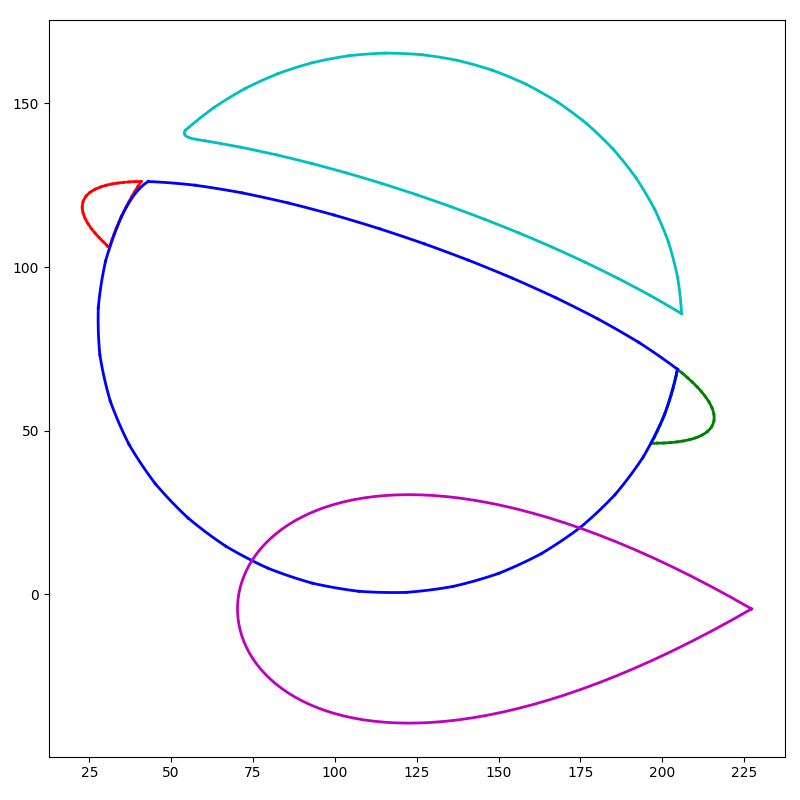

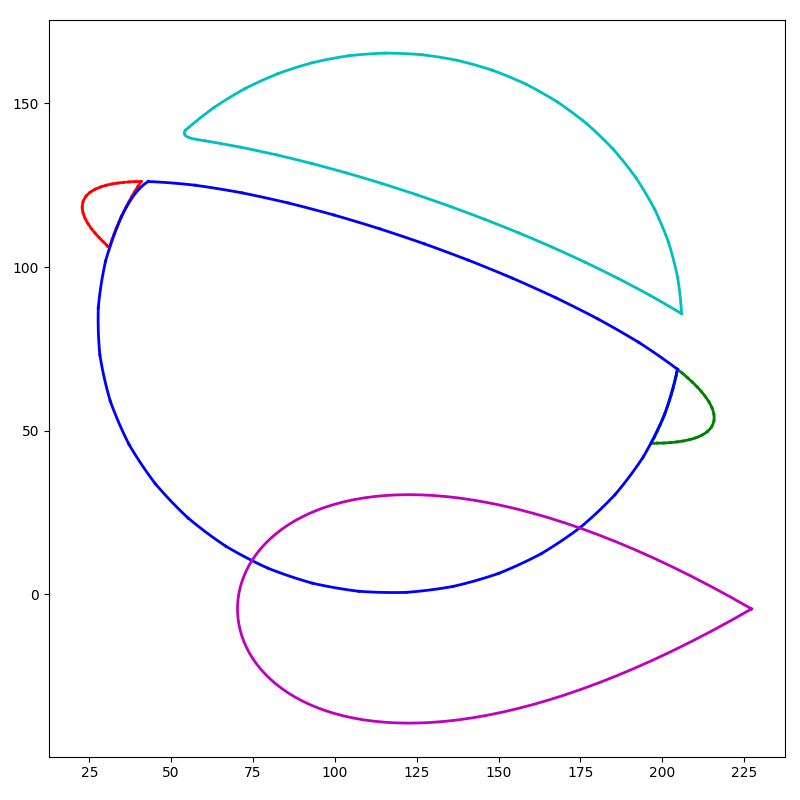

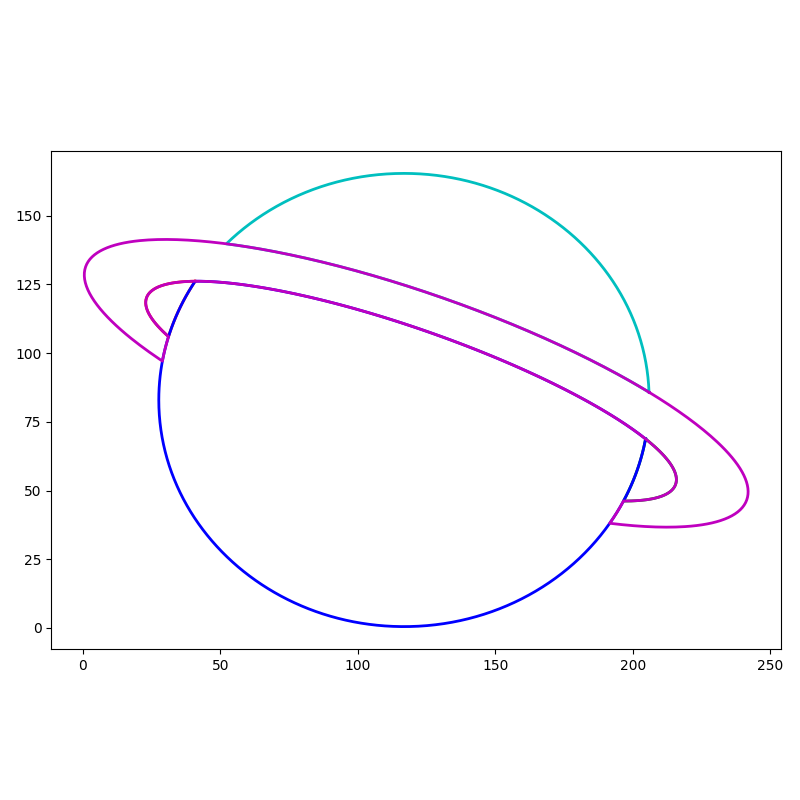

In [37]:
from IPython.display import Image, display

display(Image(filename='regularized_curves.png'))
display(Image(filename='symmetric_curves.png'))
display(Image(filename='completed_curves.png'))